In [1]:
import cv2
import pickle
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.random import set_seed
from scipy.ndimage import median_filter
from skimage.morphology import remove_small_objects

In [2]:
set_seed(42)
seed(42)

In [3]:
# shape
width = 968
height = 1292

In [4]:
feature_extractor_mika = load_model("extractor_mika.h5")
feature_extractor_kwarc = load_model("extractor_kwarc.h5")
feature_extractor_glauk = load_model("extractor_glauk.h5")

In [5]:
mika_model = pickle.load(open('RF_model_mika.sav', 'rb'))
kwarc_model = pickle.load(open('RF_model_kwarc.sav', 'rb'))
glau_model = pickle.load(open('RF_model_glau.sav', 'rb'))

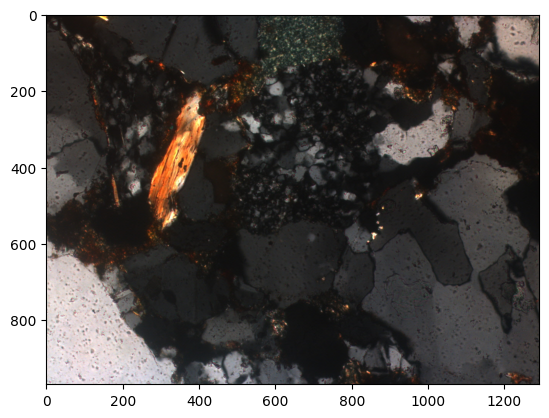

In [6]:
test_img = cv2.imread("test/19_330_xn.jpg", cv2.IMREAD_COLOR)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img)
plt.show()
test_img = np.expand_dims(test_img, axis=0)

In [7]:
X_test_feature_mika = feature_extractor_mika.predict(test_img)
X_test_feature_mika = X_test_feature_mika.reshape(-1, X_test_feature_mika.shape[3])

X_test_feature_kwarc = feature_extractor_kwarc.predict(test_img)
X_test_feature_kwarc = X_test_feature_kwarc.reshape(-1, X_test_feature_kwarc.shape[3])

X_test_feature_glauk = feature_extractor_glauk.predict(test_img)
X_test_feature_glauk = X_test_feature_glauk.reshape(-1, X_test_feature_glauk.shape[3])

1/1 [==============================] - 0s 237ms/step


In [8]:
mika = mika_model.predict(X_test_feature_mika)
kwarc = kwarc_model.predict(X_test_feature_kwarc)
glauk = glau_model.predict(X_test_feature_glauk)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    5.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    2.9s finished


In [9]:
predicted_mika = mika.reshape((968, 1292))
predicted_kwarc = kwarc.reshape((968, 1292))
predicted_glauk = glauk.reshape((968, 1292))

In [10]:
cv2.imwrite('predicted_mika.jpg', predicted_mika)
cv2.imwrite('predicted_kwarc.jpg', predicted_kwarc)
cv2.imwrite('predicted_glauk.jpg', predicted_glauk)

True

In [11]:
kernel = np.ones((7,7), np.uint8)
# predicted_mika = cv2.dilate(predicted_mika, kernel, iterations = 1)
predicted_glauk = cv2.morphologyEx(predicted_glauk, cv2.MORPH_CLOSE, kernel)

In [12]:
predicted_kwarc_bool = np.array(predicted_kwarc, dtype=bool)
predicted_mika_bool = np.array(predicted_mika, dtype=bool)
predicted_glauk_bool = np.array(predicted_glauk, dtype=bool)

In [13]:
r_im_k = remove_small_objects(predicted_kwarc_bool, min_size=100)
r_im_k.dtype='uint8'
# r_im_k = cv2.dilate(r_im_k, kernel, iterations = 1)
r_im_m = remove_small_objects(predicted_mika_bool, min_size=120)
r_im_m.dtype='uint8'
r_im_m = cv2.dilate(r_im_m, kernel, iterations = 1)
r_im_g = remove_small_objects(predicted_glauk_bool, min_size=400)
r_im_g.dtype='uint8'

In [14]:
kernel = np.ones((9,9), np.uint8)
r_im_g = cv2.morphologyEx(r_im_g, cv2.MORPH_CLOSE, kernel)

In [15]:
kernel = np.ones((7,7), np.uint8)
r_im_m = cv2.morphologyEx(r_im_m, cv2.MORPH_CLOSE, kernel)

In [16]:
r_im_k2 = median_filter(r_im_k, size=3)

In [17]:
r_im_k2[r_im_k2 == 1] = 255
r_im_g[r_im_g == 1] = 150
r_im_m[r_im_m == 1] = 75

In [18]:
results = r_im_k2 + r_im_g + r_im_m

In [19]:
results[results == 74] = 75
results[results == 149] = 150

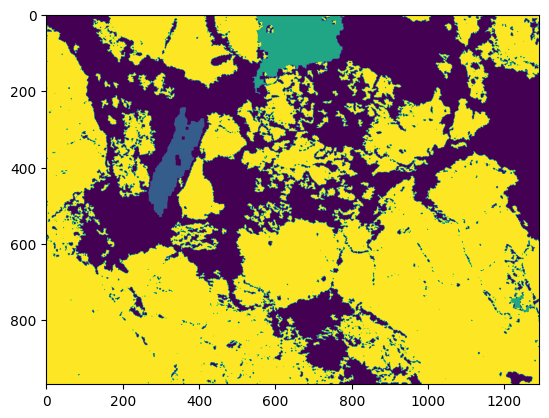

In [20]:
plt.imshow(results)

In [21]:
cv2.imwrite('result.tif', results)

True

In [22]:
np.unique(results)

array([  0,  75, 150, 255], dtype=uint8)

In [23]:
px_in_mm_2 = 0.000535 ** 2

In [24]:
n = results[results == 0].shape
an = n[0] * px_in_mm_2
an

0.129668797975

In [25]:
m = results[results == 75].shape
am = m[0] * px_in_mm_2
am

0.004653732275

In [26]:
g = results[results == 150].shape
ag = g[0] * px_in_mm_2
ag

0.008402134875

In [27]:
k = results[results == 255].shape
ak = k[0] * px_in_mm_2
ak

0.215244348475

In [28]:
ak + ag + am + an

0.3579690136

In [29]:
(predicted_glauk.shape[0] * predicted_glauk.shape[1]) * px_in_mm_2

0.3579690136

In [30]:
cv2.imwrite('r_im_k2.jpg', r_im_k2)
cv2.imwrite('r_im_g.jpg', r_im_g)
cv2.imwrite('r_im_m.jpg', r_im_m)

True